## Análisis Exploratorio

In [1]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage import io
import matplotlib.image as mpimg
from torchvision import datasets, models
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader

# Configuración de la ruta del dataset
data_dir = r'D:\1.personal\1.Clases\taller analitica\ultimo trabajo\train'

# Verificar si CUDA está disponible y seleccionar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Listar las carpetas en el directorio de datos
categories = os.listdir(data_dir)
print(f'Categorías encontradas: {categories}')


Using device: cuda
Categorías encontradas: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [2]:
# Crear transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Crear un DataFrame para almacenar información de las imágenes
data_info = []

# Recorrer las categorías y las imágenes para recopilar información
for category in categories:
    category_path = os.path.join(data_dir, category)
    images = os.listdir(category_path)
    for image_name in images:
        image_path = os.path.join(category_path, image_name)
        image = Image.open(image_path)
        image_tensor = transform(image).to(device)
        width, height = image.size
        data_info.append({
            'category': category,
            'image_name': image_name,
            'width': width,
            'height': height,
            'aspect_ratio': width / height,
            'image_tensor': image_tensor
        })

# Convertir la información a un DataFrame
df = pd.DataFrame(data_info)
print(df.head())

  category image_name  width  height  aspect_ratio  \
0      dew   2298.jpg    270     400      0.675000   
1      dew   2299.jpg    400     400      1.000000   
2      dew   2300.jpg    780     274      2.846715   
3      dew   2301.jpg    400     264      1.515152   
4      dew   2302.jpg    400     383      1.044386   

                                        image_tensor  
0  [[[tensor(0.4235, device='cuda:0'), tensor(0.4...  
1  [[[tensor(0.5569, device='cuda:0'), tensor(0.5...  
2  [[[tensor(0.0039, device='cuda:0'), tensor(0.0...  
3  [[[tensor(0.3804, device='cuda:0'), tensor(0.3...  
4  [[[tensor(0.2157, device='cuda:0'), tensor(0.2...  


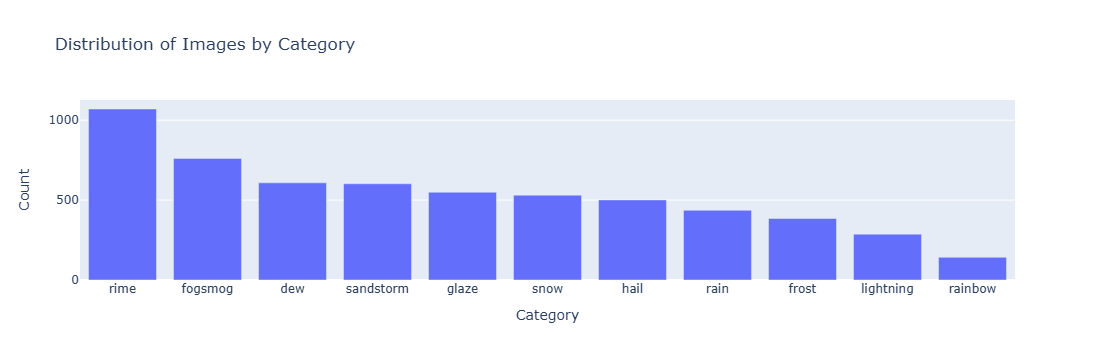

In [3]:
# Visualización de la distribución de imágenes por categoría
category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']

# Crear gráfico de barras para la distribución de categorías
fig = px.bar(category_counts, x='category', y='count',
             labels={'category': 'Category', 'count': 'Count'},
             title='Distribution of Images by Category')
fig.show()

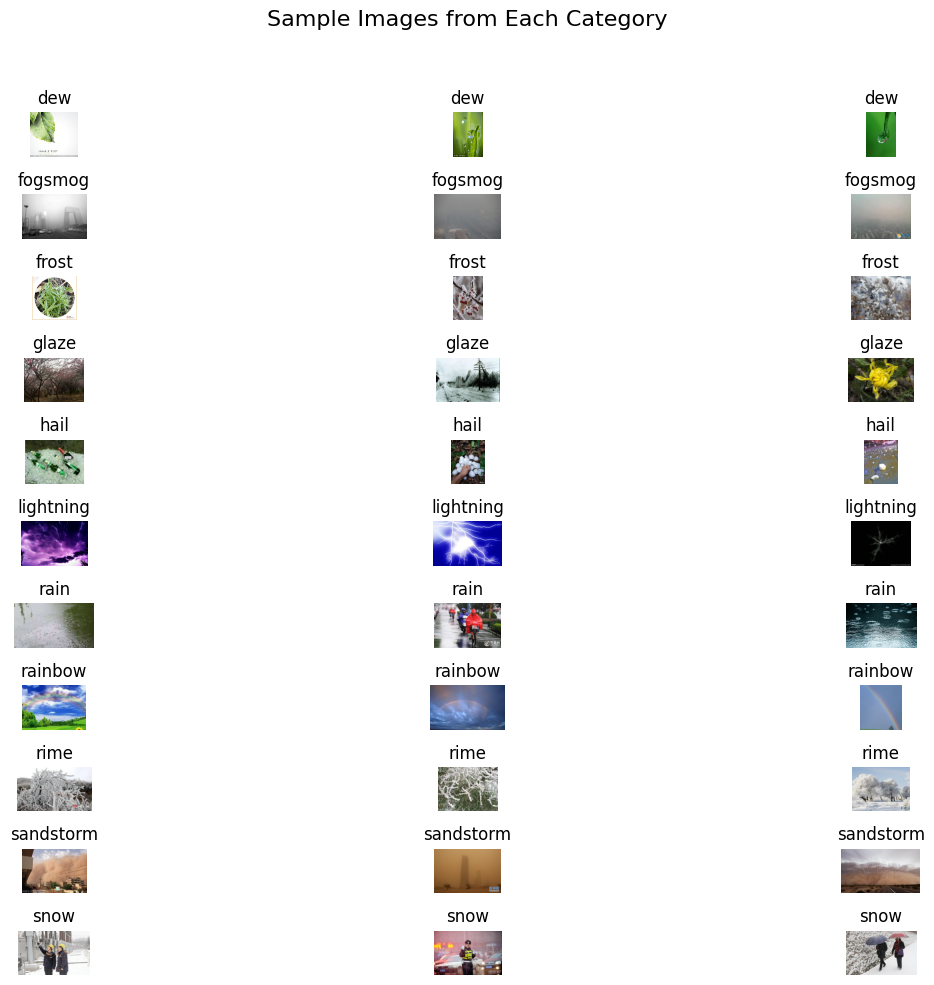

In [4]:
# Visualización de algunos ejemplos de imágenes de cada categoría de manera ordenada
def show_ordered_images(data_dir, categories, num_images=3):
    class_images = {category: [] for category in categories}
    for category in categories:
        category_path = os.path.join(data_dir, category)
        images = random.sample(os.listdir(category_path), num_images)
        for image_name in images:
            image_path = os.path.join(category_path, image_name)
            image = Image.open(image_path)
            class_images[category].append(image)

    plt.figure(figsize=(15, 10))
    i = 0
    for class_name, images in class_images.items():
        for img in images:
            i += 1
            plt.subplot(len(categories), num_images, i)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
    plt.suptitle('Sample Images from Each Category', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Mostrar imágenes aleatorias de cada categoría
show_ordered_images(data_dir, categories)


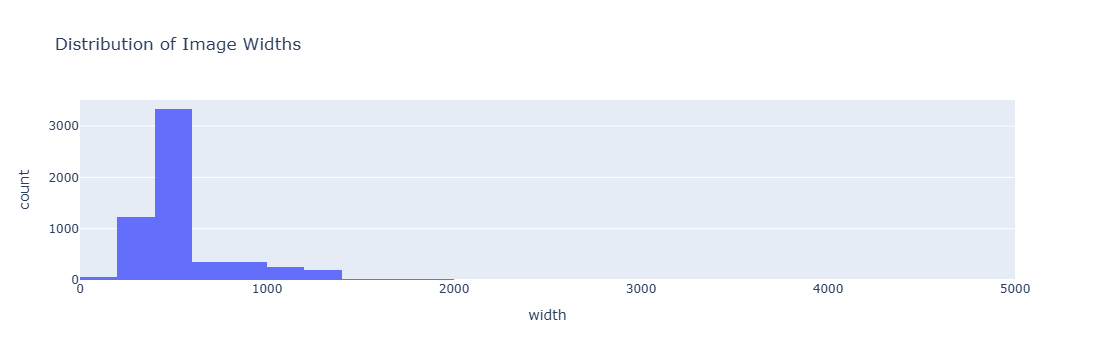

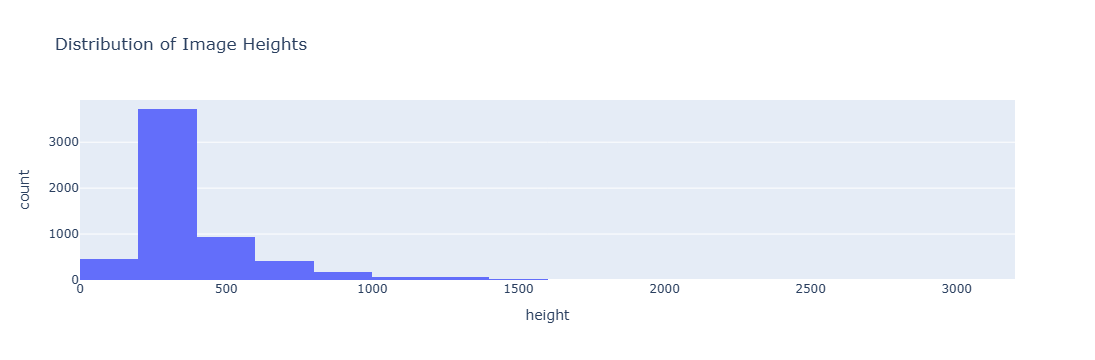

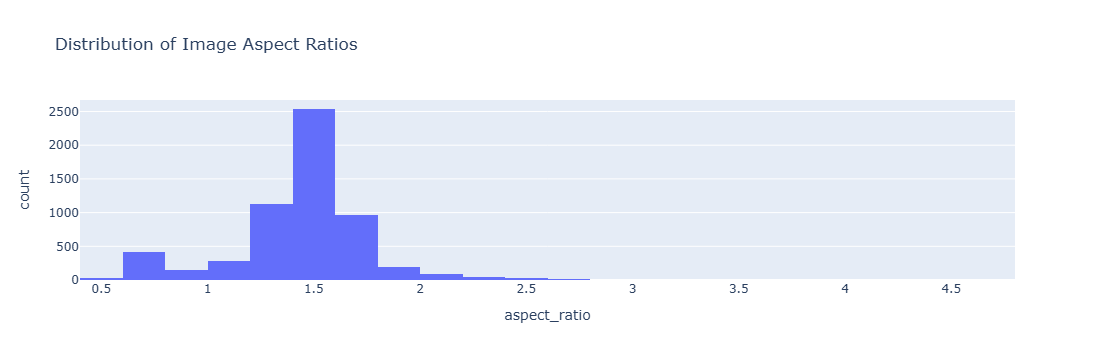

In [5]:
# Visualización de la distribución de tamaños de las imágenes
fig = px.histogram(df, x='width', nbins=30, title='Distribution of Image Widths')
fig.show()

fig = px.histogram(df, x='height', nbins=30, title='Distribution of Image Heights')
fig.show()

# Visualización de la distribución de las relaciones de aspecto de las imágenes
fig = px.histogram(df, x='aspect_ratio', nbins=30, title='Distribution of Image Aspect Ratios')
fig.show()


Iniciando plot_color_distribution
Colores recopilados
Gráfico generado, mostrando ahora...


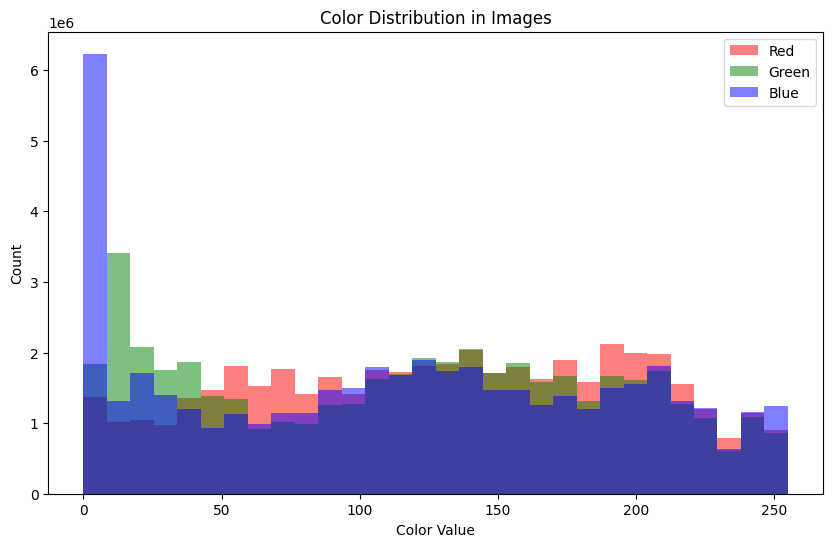

Gráfico mostrado


In [6]:
def plot_color_distribution_with_matplotlib(image_paths):
    print("Iniciando plot_color_distribution")  # Mensaje de depuración
    color_data = {'R': [], 'G': [], 'B': []}

    for image_path in image_paths:
        image = Image.open(image_path).convert('RGB')  # Asegurar que la imagen está en modo RGB
        pixels = list(image.getdata())
        r, g, b = zip(*pixels)
        color_data['R'].extend(r)
        color_data['G'].extend(g)
        color_data['B'].extend(b)
    
    print("Colores recopilados")  # Mensaje de depuración
    
    df_colors = pd.DataFrame(color_data)
    
    plt.figure(figsize=(10, 6))
    plt.hist(df_colors['R'], bins=30, alpha=0.5, label='Red', color='red')
    plt.hist(df_colors['G'], bins=30, alpha=0.5, label='Green', color='green')
    plt.hist(df_colors['B'], bins=30, alpha=0.5, label='Blue', color='blue')
    plt.title('Color Distribution in Images')
    plt.xlabel('Color Value')
    plt.ylabel('Count')
    plt.legend(loc='upper right')
    
    print("Gráfico generado, mostrando ahora...")  # Mensaje de depuración
    plt.show()
    print("Gráfico mostrado")  # Mensaje de depuración

sampled_image_paths = random.sample([os.path.join(root, name)
                                     for root, dirs, files in os.walk(data_dir)
                                     for name in files], 100)

plot_color_distribution_with_matplotlib(sampled_image_paths)

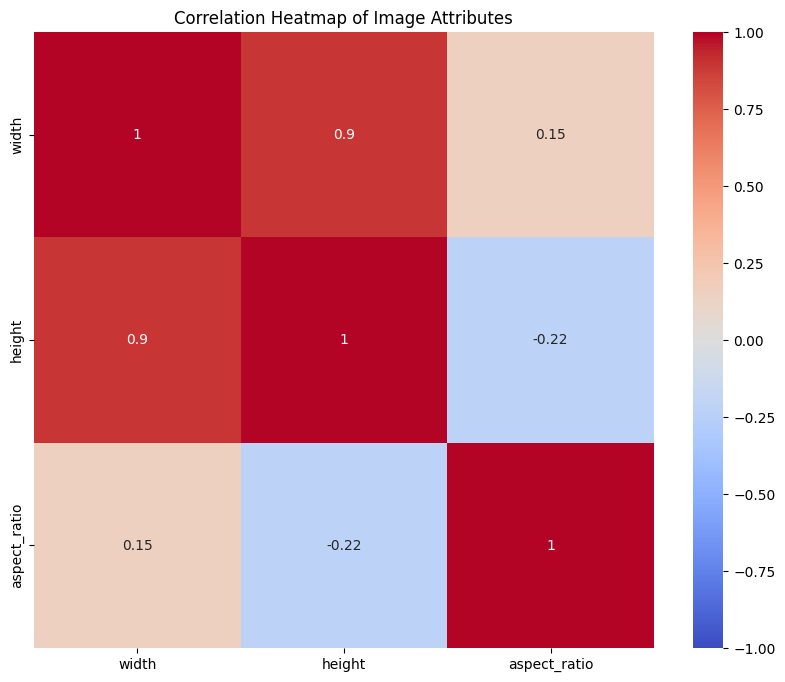

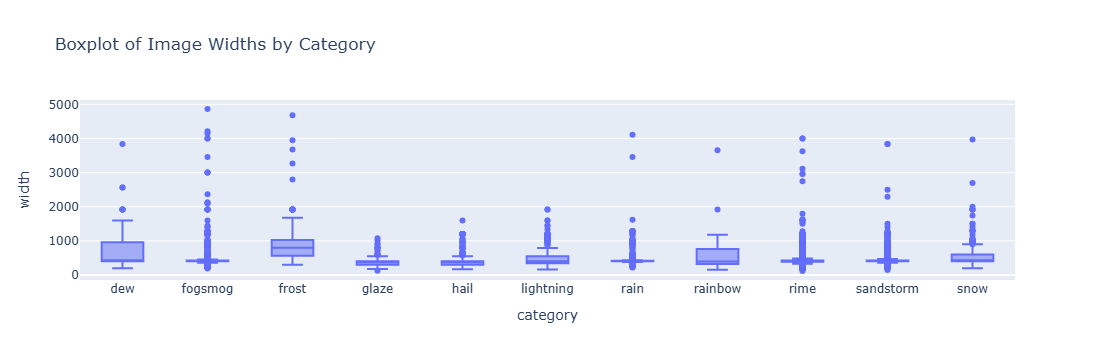

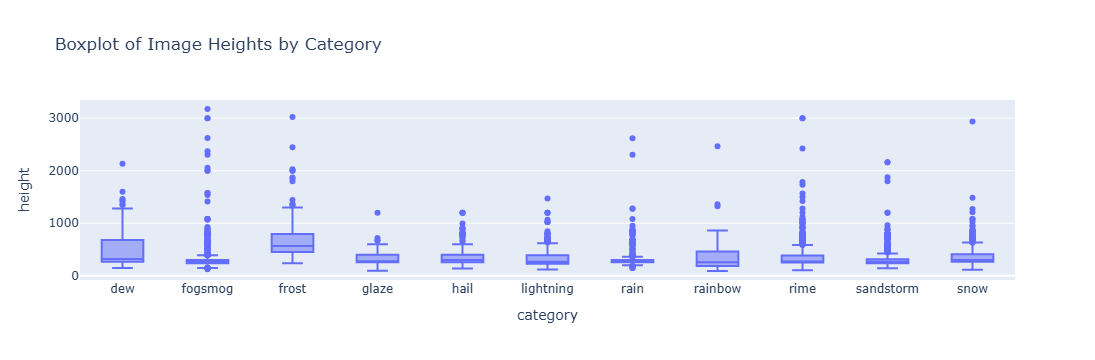

In [7]:
# Visualización de heatmaps de correlación
def plot_correlation_heatmap(df):
    correlation_matrix = df[['width', 'height', 'aspect_ratio']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap of Image Attributes')
    plt.show()

plot_correlation_heatmap(df)

# Visualización de boxplots de tamaños de imágenes
def plot_boxplots(df):
    fig = px.box(df, x='category', y='width', title='Boxplot of Image Widths by Category')
    fig.show()

    fig = px.box(df, x='category', y='height', title='Boxplot of Image Heights by Category')
    fig.show()

plot_boxplots(df)


## Entrenamiento del Modelo

In [8]:
# Configuración de la ruta del dataset
train_dir = r'D:\1.personal\1.Clases\taller analitica\ultimo trabajo\train'
test_dir = r'D:\1.personal\1.Clases\taller analitica\ultimo trabajo\test'

# Verificar si CUDA está disponible y seleccionar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [9]:
# Definir las transformaciones para la data de entrenamiento y prueba
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [10]:
# Cargar los datasets de entrenamiento y prueba
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Crear DataLoaders para los datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [11]:
# Definir el modelo de red neuronal convolucional
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, len(train_dataset.classes))
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.log_softmax(x)

model = SimpleCNN().to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [37]:
# Inicializar el modelo
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir el optimizador y la función de pérdida
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Función para evaluar el modelo
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(loader.dataset)
    total_acc = running_corrects.double() / len(loader.dataset)
    return total_loss, total_acc

In [ ]:
# Función para entrenar el modelo y registrar las métricas
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        
        print(f'Epoch {epoch+1}/{num_epochs} '
              f'Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} '
              f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
    
    return train_losses, train_accuracies, val_losses, val_accuracies

## Evaluación del modelo

In [39]:
# Entrenar el modelo y registrar las métricas
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=20)

Epoch 1/20 Train Loss: 1.3460 Train Acc: 0.5513 Val Loss: 1.2530 Val Acc: 0.5909
Epoch 2/20 Train Loss: 1.0162 Train Acc: 0.6512 Val Loss: 1.2112 Val Acc: 0.6323
Epoch 3/20 Train Loss: 0.9162 Train Acc: 0.6936 Val Loss: 1.0065 Val Acc: 0.6808
Epoch 4/20 Train Loss: 0.8438 Train Acc: 0.7137 Val Loss: 1.0621 Val Acc: 0.6657
Epoch 5/20 Train Loss: 0.7846 Train Acc: 0.7296 Val Loss: 1.0065 Val Acc: 0.6667
Epoch 6/20 Train Loss: 0.7237 Train Acc: 0.7517 Val Loss: 0.9933 Val Acc: 0.6848
Epoch 7/20 Train Loss: 0.6915 Train Acc: 0.7597 Val Loss: 0.9716 Val Acc: 0.7010
Epoch 8/20 Train Loss: 0.6084 Train Acc: 0.7853 Val Loss: 1.0365 Val Acc: 0.6929
Epoch 9/20 Train Loss: 0.5705 Train Acc: 0.8004 Val Loss: 0.9723 Val Acc: 0.6939
Epoch 10/20 Train Loss: 0.5141 Train Acc: 0.8188 Val Loss: 1.0898 Val Acc: 0.6848
Epoch 11/20 Train Loss: 0.4663 Train Acc: 0.8363 Val Loss: 1.1473 Val Acc: 0.6556
Epoch 12/20 Train Loss: 0.4303 Train Acc: 0.8522 Val Loss: 1.1393 Val Acc: 0.6960
Epoch 13/20 Train Loss: 0

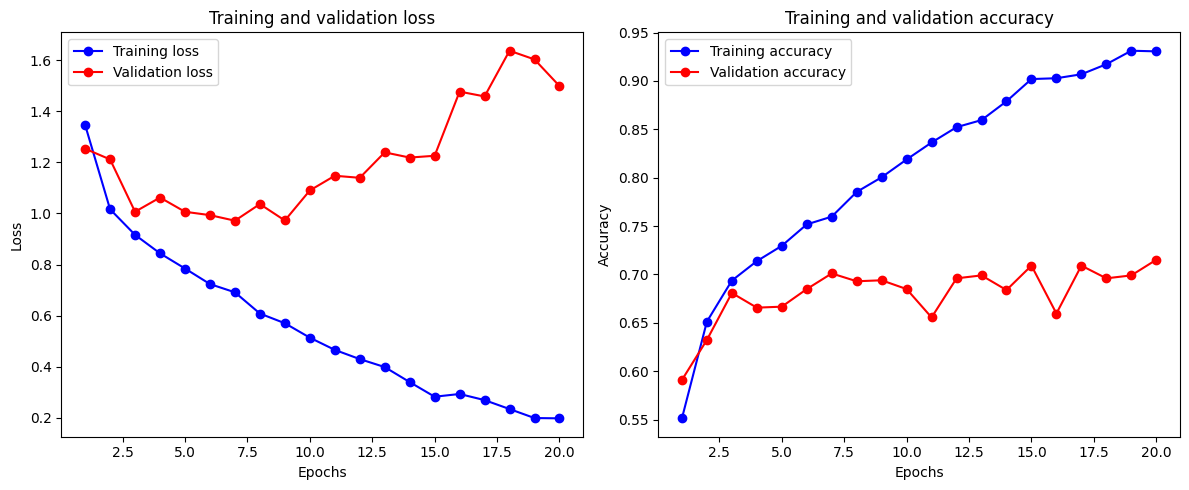

In [40]:
# Función para graficar las curvas de precisión y pérdida
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Curva de Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Curva de Precisión
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Graficar las curvas de precisión y pérdida
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)

## Guardar Modelo 

In [41]:
# Guardar el modelo entrenado
torch.save(model.state_dict(), r'D:\1.personal\1.Clases\taller analitica\ultimo trabajo\model.pth')

## Testeo del Modelo con imagen Random

In [46]:
# Función para cargar y transformar una imagen
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch
    return image

# Definir las transformaciones para la imagen de prueba
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Seleccionar una imagen de prueba de manera aleatoria
def get_random_image_path(test_dir):
    categories = os.listdir(test_dir)
    random_category = random.choice(categories)
    category_path = os.path.join(test_dir, random_category)
    image_name = random.choice(os.listdir(category_path))
    return os.path.join(category_path, image_name)

# Obtener la ruta de una imagen aleatoria
test_image_path = get_random_image_path(test_dir)
print(f'Selected test image: {test_image_path}')

# Cargar y transformar la imagen
test_image = load_and_transform_image(test_image_path, test_transform).to(device)


Selected test image: D:\1.personal\1.Clases\taller analitica\ultimo trabajo\test\glaze\6151.jpg


The predicted class is: glaze
Predicted class index: 3
Predicted class: glaze


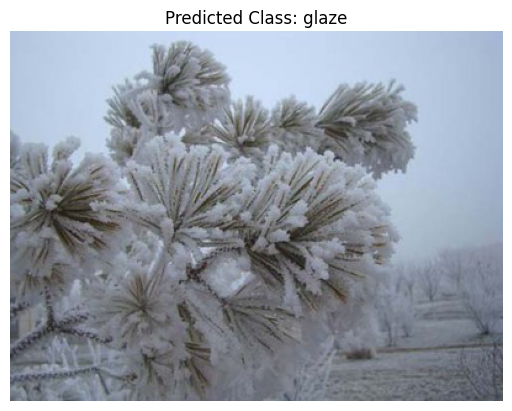

In [43]:
# Función para realizar la predicción
def predict_image(model, image):
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return preds.item()

# Cargar el modelo entrenado
model.load_state_dict(torch.load(r'D:\1.personal\1.Clases\taller analitica\ultimo trabajo\model.pth'))
model = model.to(device)

# Realizar la predicción
predicted_class_index = predict_image(model, test_image)
predicted_class = train_dataset.classes[predicted_class_index]

print(f'The predicted class is: {predicted_class}')

# Visualizar la imagen y la predicción
def show_image_and_prediction(image_path, predicted_class):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

# Realizar la predicción
predicted_class_index = predict_image(model, test_image)
predicted_class = test_dataset.classes[predicted_class_index]

# Verificar que la predicción es correcta
print(f'Predicted class index: {predicted_class_index}')
print(f'Predicted class: {predicted_class}')

# Mostrar la imagen y la predicción
show_image_and_prediction(test_image_path, predicted_class)

## Explicación del modelo mediante Lime

Model loaded from D:\1.personal\1.Clases\taller analitica\ultimo trabajo\model.pth
Predicted class index: 3
Predicted class: glaze


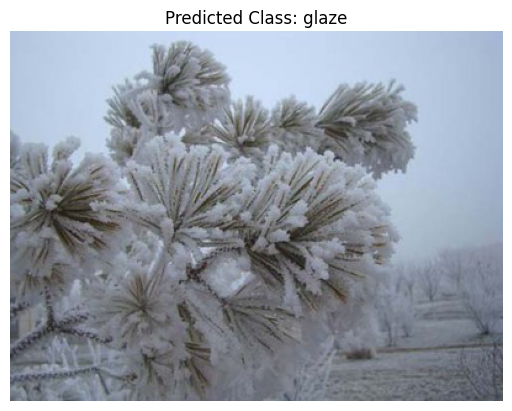

  0%|          | 0/1000 [00:00<?, ?it/s]

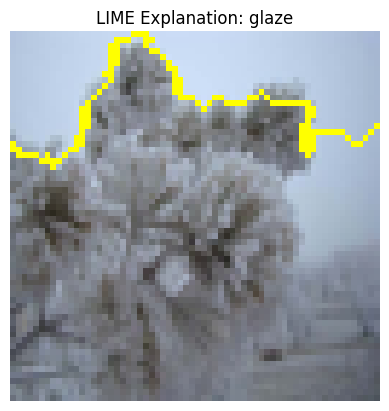

In [44]:
# Cargar el modelo entrenado
model_path = r'D:\1.personal\1.Clases\taller analitica\ultimo trabajo\model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
print(f'Model loaded from {model_path}')

# Función para realizar la predicción
def predict_image(model, image):
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return preds.item()

# Realizar la predicción
predicted_class_index = predict_image(model, test_image)
predicted_class = train_dataset.classes[predicted_class_index]

# Verificar que la predicción es correcta
print(f'Predicted class index: {predicted_class_index}')
print(f'Predicted class: {predicted_class}')

# Visualizar la imagen y la predicción
def show_image_and_prediction(image_path, predicted_class):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

# Mostrar la imagen y la predicción
show_image_and_prediction(test_image_path, predicted_class)

# Usar LIME para explicar la predicción
def transform_image_for_lime(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.array(image.resize((64, 64)))
    return image

explainer = lime_image.LimeImageExplainer()

def batch_predict(images):
    model.eval()
    batch = torch.stack([test_transform(Image.fromarray(img)).to(device) for img in images], dim=0)
    with torch.no_grad():
        logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

# Transformar la imagen para LIME
image_for_lime = transform_image_for_lime(test_image_path)

# Explicar la predicción
explanation = explainer.explain_instance(image_for_lime, batch_predict, top_labels=5, hide_color=0, num_samples=1000)

# Mostrar la explicación
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
img_boundry = mark_boundaries(temp / 255.0, mask)

plt.imshow(img_boundry)
plt.title(f'LIME Explanation: {predicted_class}')
plt.axis('off')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..232.0].


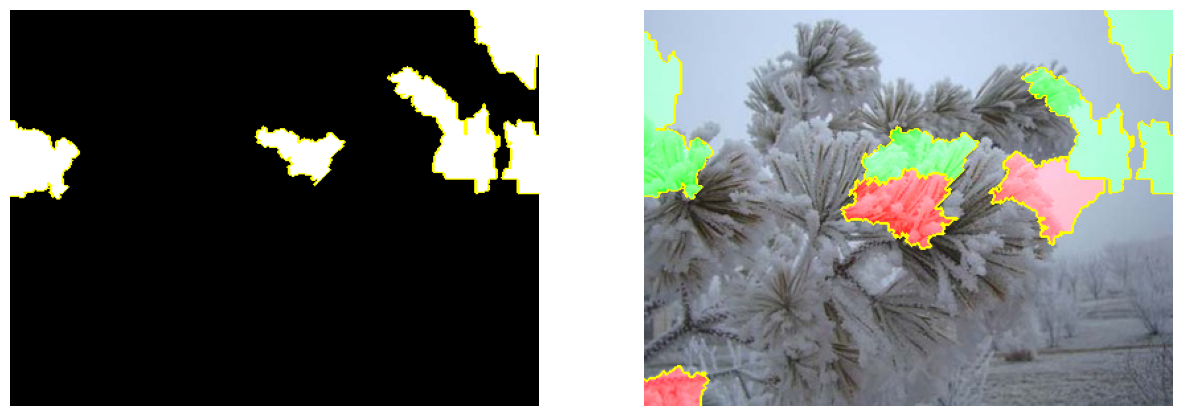

In [45]:
# Cargar el modelo entrenado de PyTorch
model_path = r'D:\1.personal\1.Clases\taller analitica\ultimo trabajo\model.pth'

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 11)  # Cambia 5 por el número de clases en tu dataset
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.log_softmax(x)

model = SimpleCNN()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Definir las transformaciones para la imagen de prueba
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Función para leer y transformar la imagen
def read_and_transform_img(url):
    img = Image.open(url).convert('RGB')
    img = test_transform(img).unsqueeze(0)
    return img

url = test_image_path

images = read_and_transform_img(url)

# Función de predicción para LIME
def batch_predict(images):
    model.eval()
    images = torch.stack([test_transform(Image.fromarray(img)) for img in images], dim=0)
    images = images.to(torch.device('cpu'))
    outputs = model(images)
    outputs = torch.nn.functional.softmax(outputs, dim=1)
    return outputs.detach().cpu().numpy()

# Usar LIME para explicar la predicción
image_for_lime = io.imread(url)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image_for_lime, batch_predict, top_labels=3, hide_color=0, num_samples=1000)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

# Visualizar las explicaciones
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')
plt.show()
